In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from rfpimp import *

In [3]:
df = pd.read_csv("rent.csv", parse_dates=['created'])
df_clean = df[(df.price>1_000) & (df.price<10_000)]
df_clean = df_clean[(df_clean.longitude!=0) | (df_clean.latitude!=0)]
df_clean = df_clean[(df_clean['latitude']>40.55) &
                    (df_clean['latitude']<40.94) &
                    (df_clean['longitude']>-74.1) &
                    (df_clean['longitude']<-73.67)]
df = df_clean

In [4]:
numfeatures = ['bathrooms', 'bedrooms', 'longitude', 'latitude']
X, y = df[numfeatures], df['price']
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
rf.fit(X, y)
oob_baseline = rf.oob_score_
print(oob_baseline)

0.8669058460778184


In [5]:
print(f"{rfnnodes(rf):,d} tree nodes and {np.median(rfmaxdepths(rf))} median tree height")

2,432,708 tree nodes and 35.0 median tree height


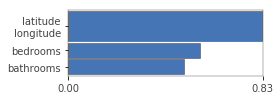

In [6]:
def showimp(rf, X, y):
    features = list(X.columns)
    features.remove('latitude')
    features.remove('longitude')
    features += [['latitude','longitude']]

    I = importances(rf, X, y, features=features)
    plot_importances(I, color='#4575b4')
    
showimp(rf, X, y)

In [7]:
print(df['interest_level'].value_counts())

low       33270
medium    11203
high       3827
Name: interest_level, dtype: int64


In [8]:
df['interest_level'] = df['interest_level'].map({'low':1,'medium':2,'high':3})
print(df['interest_level'].value_counts())

1    33270
2    11203
3     3827
Name: interest_level, dtype: int64


In [9]:
def test(X, y):
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    rf.fit(X, y)
    oob = rf.oob_score_
    n = rfnnodes(rf)
    h = np.median(rfmaxdepths(rf))
    print(f"OOB R^2 {oob:.5f} using {n:,d} tree nodes with {h} median tree height")
    return rf, oob

X, y = df[['interest_level']+numfeatures], df['price']
rf, oob = test(X, y)

OOB R^2 0.87059 using 3,023,256 tree nodes with 35.0 median tree height


In [10]:
print(len(df['manager_id'].unique()), len(df['building_id'].unique()), len(df['display_address'].unique()))

3409 7417 8680


In [11]:
df['display_address_cat'] = df['display_address'].astype('category').cat.as_ordered()
df['display_address_cat'] = df['display_address_cat'].cat.codes + 1

In [12]:
X, y = df[['display_address_cat']+numfeatures], df['price']
rf, oob = test(X, y)

OOB R^2 0.86575 using 3,123,076 tree nodes with 38.0 median tree height


In [13]:
print(df['manager_id'].value_counts().head(5))

e6472c7237327dd3903b3d6f6a94515a    2509
6e5c10246156ae5bdcd9b487ca99d96a     695
8f5a9c893f6d602f4953fcc0b8e6e9b4     404
62b685cc0d876c3a1a51d63a0d6a8082     396
cb87dadbca78fad02b388dc9e8f25a5b     370
Name: manager_id, dtype: int64


In [14]:
managers_count = df['manager_id'].value_counts()
df['mgr_apt_count'] = df['manager_id'].map(managers_count)

In [15]:
X, y = df[['display_address_cat','mgr_apt_count']+numfeatures], df['price']
rf, oob = test(X, y)

OOB R^2 0.86487 using 4,569,538 tree nodes with 40.0 median tree height
